In [1]:
from pandas import DataFrame
import pandas_profiling
import numpy as np
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import pearsonr, mstats

from statsmodels.stats.stattools import jarque_bera
init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
data = DataFrame.from_csv("./testosterone_levels.csv")

In [3]:
testosterones = [p.Testosterone for _, p in data.groupby("Person")]

In [4]:
# whole population
mean_std = np.array([[t.mean(), t.std()] for t in testosterones])
cv = mean_std[:,1] / mean_std[:,0]

# gender specific population
gender = data.groupby("Person").first()['F1']
male = data[data['F1'] == 1]
female = data[data['F1'] == 2]
male_testosterones = [p.Testosterone for _, p in male.groupby("Person")]
female_testosterones = [p.Testosterone for _, p in female.groupby("Person")]

mean_std_male = np.array([[t.mean(), t.std()] for t in male_testosterones])
mean_std_female = np.array([[t.mean(), t.std()] for t in female_testosterones])
cv_male = mean_std_male[:,1] / mean_std_male[:,0]
cv_female = mean_std_female[:,1] / mean_std_female[:,0]

## Normality Tests

In [5]:
# Pearson test of normality for inter-individual mean, variances and cv
def normaltest(a, method='jb'):
    if method == 'pearson':
        p = mstats.normaltest(a, axis=0).pvalue
        p_log = mstats.normaltest(np.log2(a), axis=0).pvalue
        print("Pearson test of normality is being used...")
    else:
        p = jarque_bera(a)[1]
        p_log = jarque_bera(np.log(a))[1]
    
    if p > 0.01:
        print('distribution is normal')
    else: # check for log-normality
        
        if p_log > 0.01:
            print('distribution is log-normal')
        else:
            print('distribution is neither normal nor log-normal!!')
            
            
print("Mean", end=' '); normaltest(mean_std[:,0])
print("Variance", end=' '); normaltest(mean_std[:,1])
print("Coefficient of variation", end=' '); normaltest(cv)

Mean distribution is neither normal nor log-normal!!
Variance distribution is log-normal
Coefficient of variation distribution is log-normal


## Correlation Tests

In [6]:
# pearson correlation of log distribution of mean and variance
corr = pearsonr(np.log(mean_std[:,0]), np.log(mean_std[:,1]))
corr_cv_mean = pearsonr(np.log(mean_std[:,0]), np.log(cv))
print("Log-Mean vs. Log-Variance correlation:")
print("Correlation value: {0}, p_value: {1}".format(corr[0], corr[1]))
print("Log-Mean vs. Log-CV correlation:")
print("Correlation value: {0}, p_value: {1}".format(corr_cv_mean[0], corr_cv_mean[1]))

Log-Mean vs. Log-Variance correlation:
Correlation value: 0.8672156948341208, p_value: 5.1335477815650085e-43
Log-Mean vs. Log-CV correlation:
Correlation value: 0.1427745936888417, p_value: 0.09481347358741259


## CV distribution of Testosterone

In [213]:
mu_log_cv, std_log_cv = norm.fit(np.log(cv))

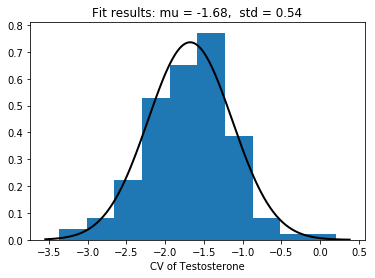

In [214]:
# Plot the PDF.
plt.hist(np.log(cv), normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p = norm.pdf(x, mu_cv, std_cv)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu_cv, std_cv)
plt.title(title)
plt.xlabel("CV of Testosterone")
plt.show()

## Mean distribution of Testosterone

mu1: 0.65, mu2: 2.31, sigma1: 0.32, sigma2: 0.48


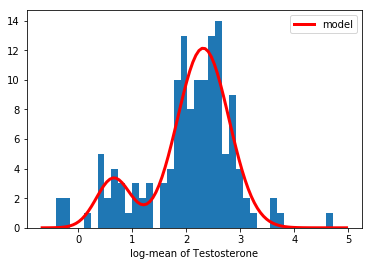

In [10]:
def bimodal(x,mu1,sigma1, a ,mu2,sigma2, b):
    return a * norm.pdf(x, loc=mu1, scale=sigma1) + b* norm.pdf(x, loc=mu2, scale=sigma2)

y, x, _ = plt.hist(np.log(mean_std[:,0]), bins=40)

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(.9,.3,5, 2,.5, 25)
params,cov = curve_fit(bimodal,x, y, expected)

x_min, x_max = plt.xlim()
x_range = np.linspace(x_min, x_max, 100)

plt.plot(x_range, bimodal(x_range,*params),color='red',lw=3,label='model')
plt.xlabel("log-mean of Testosterone")

plt.legend()
print("mu1: %.2f, mu2: %.2f, sigma1: %.2f, sigma2: %.2f" % (params[0], params[3], params[1], params[4]))
# params: [0.65971149 2.3118089 0.31358743 0.48161179]

In [230]:
def joint_prob(log_mu, log_sigma, mu_log_mu, std_log_mu, mu_log_cv, std_log_cv):

    log_cv = log_sigma - log_mu
    
    p_mu = norm.pdf(log_mu, loc=mu_log_mu, scale=std_log_mu)
    p_cv = norm.pdf(log_cv, loc=mu_log_cv, scale=std_log_cv)
    
    return log_mu * p_cv * p_mu

def products(log_observations, log_mu, log_sigma):
    return np.product([norm.pdf(obs, loc=log_mu, scale=log_sigma) for obs in log_observations])

def dist(log_mu, log_sigma, log_observations, log_mu_mu, log_std_mu, log_mu_cv, log_std_cv):
    
    return products(log_observations, log_mu, log_sigma) * joint_prob(log_mu, log_sigma, log_mu_mu, log_std_mu, log_mu_cv, std_log_cv)

## Gender Specific Mean Distribution

mu_log_mu_male: 2.393652448985088 
 std_log_mu_male: 0.4975949035276396 
 mu_log_mu_female: 0.7679896207224753 
 std_log_mu_female: 0.6064513206209803


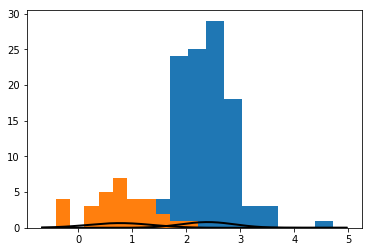

In [207]:
mu_log_mu_male, std_log_mu_male = norm.fit(np.log(mean_std_male[:,0]))
mu_log_mu_female, std_log_mu_female = norm.fit(np.log(mean_std_female[:,0]))

# Plot the PDF.
plt.hist(np.log(mean_std_male[:,0]))
plt.hist(np.log(mean_std_female[:,0]))
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 200)
p_male = norm.pdf(x, mu_log_mu_male, std_log_mu_male)
p_female = norm.pdf(x, mu_log_mu_female, std_log_mu_female)
plt.plot(x, p_male, 'k', linewidth=2)
plt.plot(x, p_female, 'k', linewidth=2)
print("mu_log_mu_male:", mu_log_mu_male, "\n", "std_log_mu_male:", std_log_mu_male, "\n", "mu_log_mu_female:", mu_log_mu_female, "\n", "std_log_mu_female:", std_log_mu_female)
plt.show()

## Evaluation of Joint Distribution

(array([3., 4., 1., 1., 0., 0., 0., 0., 0., 1.]),
 array([  2.2867313 ,  15.14757272,  28.00841413,  40.86925554,
         53.73009695,  66.59093836,  79.45177977,  92.31262118,
        105.17346259, 118.03430401, 130.89514542]),
 <a list of 10 Patch objects>)

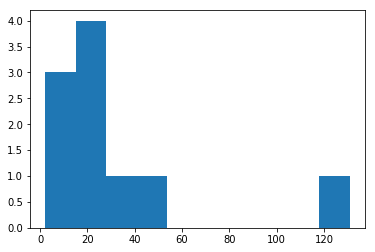

In [228]:
plt.hist(simulated_data)

(array([1., 0., 0., 2., 1., 3., 1., 1., 0., 1.]),
 array([0.82712342, 1.23185074, 1.63657805, 2.04130537, 2.44603269,
        2.85076   , 3.25548732, 3.66021464, 4.06494195, 4.46966927,
        4.87439659]),
 <a list of 10 Patch objects>)

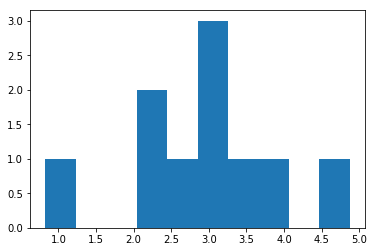

In [229]:
plt.hist(np.log(simulated_data))

In [197]:
simulated_data = np.exp(norm.rvs(loc=3, scale=1, size=10))

In [223]:
print("Range:", np.log(np.linspace(1,500, 10)))
print("Target:",np.log(simulated_data[-1]))

Range: [0.         4.03325687 4.71750632 5.11998783 5.40617476 5.62842015
 5.81014249 5.96386494 6.09707503 6.2146081 ]
Target: 3.02045083702403


In [224]:
from scipy.integrate import dblquad
def f(x): return dblquad(dist, 0, 10, lambda x: 0, lambda x: 5, args=[np.log(np.append(simulated_data[:-1], x)) , mu_log_mu_male, std_log_mu_male, mu_log_cv, std_log_cv])[0]

In [226]:
predictive_dist = [f(x) for x in np.log(np.linspace(1,500, 10))]

/home/iss/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



In [227]:
predictive_dist

[0.0,
 1.1093600399550028e-07,
 1.2852629327895069e-07,
 1.3797058777247898e-07,
 1.4428014484410582e-07,
 1.4896010441776466e-07,
 1.5263940651394204e-07,
 1.5561638256464978e-07,
 1.5815271292013037e-07,
 1.6037113178893837e-07]